In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Carga de Datos

In [2]:
data=pd.read_csv('demanda.csv',dayfirst=True,thousands='.',parse_dates=True,index_col='TIPO')
data.head()

,Residencial,Comercial,Industrial/Comercial Grande,TOTAL
TIPO,,,,
2015-01-01,5096406,3362160,3247624,11706190
2015-02-01,4438153,3076341,3150592,10665087
2015-03-01,4823968,3263679,3460880,11548527
2015-04-01,3756853,2962997,3306585,10026435
2015-05-01,4224673,2979187,3263774,10467634


In [3]:
data.describe().round(2)

,Residencial,Comercial,Industrial/Comercial Grande,TOTAL
count,44.00,44.00,44.00,44.00
mean,4745018.02,3193531.25,3201238.93,11139788.20
std,627095.26,193716.15,107030.91,764343.47
min,3754330.00,2900824.00,2950818.00,9793759.00
25%,4222957.00,3038991.25,3122472.25,10466094.50
50%,4715575.50,3151394.50,3215652.00,11126247.50
75%,5201443.25,3312377.75,3266523.25,11800556.25
max,6167114.00,3670275.00,3460880.00,12605842.00


/home/vanessa/miniconda3/envs/diplodatos-ayv/lib/python3.5/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


Text(0,0.5,'$Minutos$ $[Miles]$')

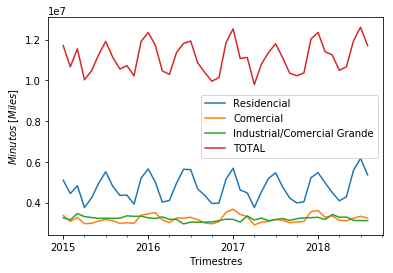

In [4]:
data.plot(y=['Residencial','Comercial','Industrial/Comercial Grande','TOTAL'],
          kind='line')
plt.xlabel('Trimestres')
plt.ylabel(r'$Minutos$ $[Miles]$')

Se procederá a analizar la serie temporal de las demandas totales y a descomponer la misma en los patrones tendencia, estacional e irregular. Para hacer este proceso se usa el método X-13 ARIMA-SEATS.

In [5]:
y=data['TOTAL']
descomposicion = sm.tsa.x13_arima_analysis(y,x12path='.')

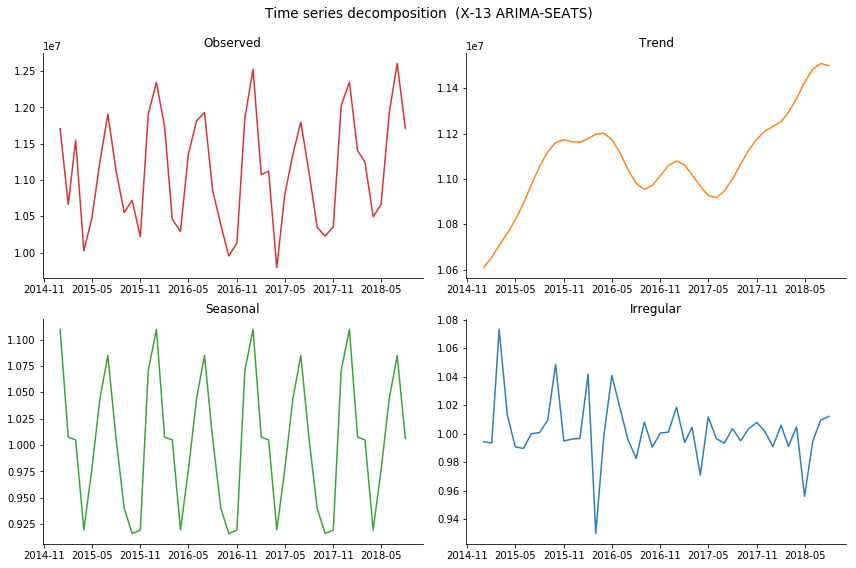

In [6]:
from plotting import plot_components_x13
plot_components_x13(descomposicion)
plt.show()

Bien, la tendencia de esta serie temporal es creciente con baches en el periodo de mitad del 2016 a la mitad del 2017, también se puede observar que los órdenes en magnitud de las distintas componentes son bien diferenciados, siendo dominada principalmente por la componente estacional y en menor medida por la componente irregular.

Se observa como la serie temporal es ajustada removiendo la estacionalidad.

TIPO
2018-04-01    1.140990e+07
2018-05-01    1.092209e+07
2018-06-01    1.142037e+07
2018-07-01    1.161864e+07
2018-08-01    1.163825e+07
Name: seasadj, dtype: float64

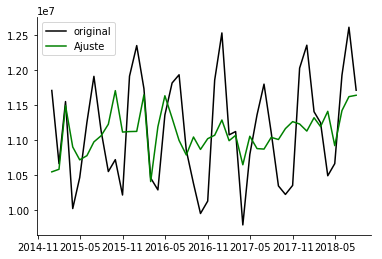

In [7]:
estacionalidad=descomposicion.seasadj
display(estacionalidad.tail())

f=plt.plot(y,color='black')
f1=plt.plot(estacionalidad,color='green')
plt.legend((f[0],f1[0]),('original','Ajuste'))
xlabel='Periodos'
ylabel='TOTAL'
title='Total de demandas'
sns.despine()
plt.show()

Es claro que no observemos un buen ajuste dado que el holt solo considera tendencia y no tiene encuenta el termino de estacionalidad. Acontinuación veremos en mas detalle este analisis usando *Holt-winters exponential smoothing*.

## Holt-winters exponential smoothing

Observando la primer figura podemos previamente apostar a que el mejor modelo de Holt-winters exponential smoothing será uno donde damped=False ya que vemos que la tendencia no disminuye con el tiempo, mas allá de las caídas que se encuentran en la misma. También será de tipo aditivo puesto que la estacionalidad no varia a lo largo de la serie temporal. 

Sin embargo veamos entoces cual es el mejor modelo.

Tenemos en cuenta que los valores de la serie temporal son cada un mes, por lo que se toma un valor para el parámetro $m=12$.

In [8]:
def hw_summary(model_sm):
    alpha_sm = model_sm.model.params['smoothing_level']
    betha_sm = model_sm.model.params['smoothing_slope']
    delta_sm = model_sm.model.params['smoothing_seasonal']
    mse_sm = sm.tools.eval_measures.mse(model_sm.data.endog,model_sm.fittedvalues)
    rmse_sm = sm.tools.eval_measures.rmse(model_sm.data.endog,model_sm.fittedvalues)
    print(' Smoothing parameter: alpha  {0:.3f}'.format(alpha_sm))
    print(' Smoothing parameter: betha  {0:.3f}'.format(betha_sm))
    print(' Smoothing parameter: delta  {0:.3f}'.format(delta_sm))
    print(' In-sample fit:')
    print(' MSE               {0:.3f}'.format(mse_sm))
    print(' RMSE               {0:.3f}'.format(rmse_sm))
    return rmse_sm

In [9]:
modelES_1=sm.tsa.ExponentialSmoothing(y, trend='add', damped=False, seasonal='add', 
                                   seasonal_periods=12).fit()
hw_summary(modelES_1)

/home/vanessa/miniconda3/envs/diplodatos-ayv/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


 Smoothing parameter: alpha  0.053
 Smoothing parameter: betha  0.053
 Smoothing parameter: delta  0.421
 In-sample fit:
 MSE               152389189756.987
 RMSE               390370.580


390370.58003516024

In [10]:
modelES_2=sm.tsa.ExponentialSmoothing(y, trend='mul', damped=False, seasonal='add', 
                                   seasonal_periods=12).fit()
hw_summary(modelES_2)

/home/vanessa/miniconda3/envs/diplodatos-ayv/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


 Smoothing parameter: alpha  1.000
 Smoothing parameter: betha  1.000
 Smoothing parameter: delta  0.000
 In-sample fit:
 MSE               5244462803440239.000
 RMSE               72418663.364


72418663.36408204

In [11]:
modelES_3=sm.tsa.ExponentialSmoothing(y, trend='add', damped=False, seasonal='mul', 
                                   seasonal_periods=12).fit()
hw_summary(modelES_3)

/home/vanessa/miniconda3/envs/diplodatos-ayv/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


 Smoothing parameter: alpha  0.053
 Smoothing parameter: betha  0.053
 Smoothing parameter: delta  0.421
 In-sample fit:
 MSE               122864163265.591
 RMSE               350519.847


350519.8471778615

In [12]:
modelES_4=sm.tsa.ExponentialSmoothing(y, trend='mul', damped=False, seasonal='mul', 
                                   seasonal_periods=12).fit()
hw_summary(modelES_4)

/home/vanessa/miniconda3/envs/diplodatos-ayv/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


 Smoothing parameter: alpha  1.000
 Smoothing parameter: betha  1.000
 Smoothing parameter: delta  0.000
 In-sample fit:
 MSE               2380711535443130880.000
 RMSE               1542955454.783


1542955454.7825193

Elijo el modelo_1 y el modelo_3 ya que presentan las mejores exactitudes. veamos entonces el comportamiento de los valores residuales:

# Dianostico de los modelos 

In [13]:
residuos_1 = (y-modelES_1.fittedvalues) 
residuos_3 = (y-modelES_3.fittedvalues)

/home/vanessa/miniconda3/envs/diplodatos-ayv/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


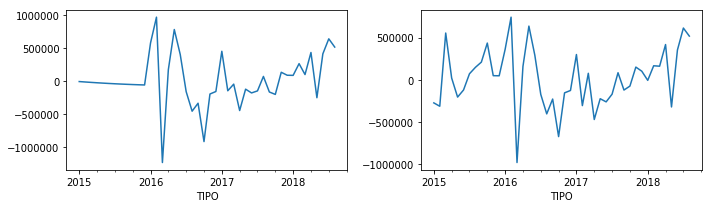

In [14]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True,
                        tight_layout=True,figsize=(10,3))
plt.subplot(121)
residuos_1.plot()

plt.subplot(122)
residuos_3.plot()

plt.show()


/home/vanessa/miniconda3/envs/diplodatos-ayv/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


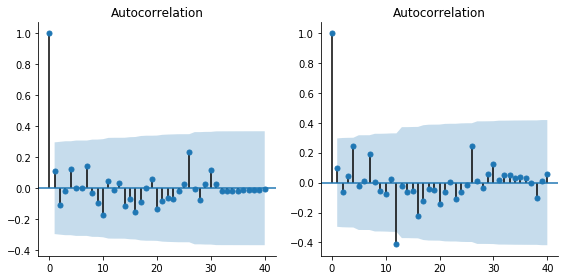

In [15]:
#fig, ax = plt.subplots(1,2,figsize=(9,6))
plt.rcParams['figure.figsize'] = 8, 4
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True,
                        tight_layout=True)
ax1 = plt.subplot(121)
sm.graphics.tsa.plot_acf(residuos_1, lags=40, ax=ax1)
sns.despine()
ax2 = plt.subplot(122)
sm.graphics.tsa.plot_acf(residuos_3, lags=40, ax = ax2)
sns.despine()

plt.show()



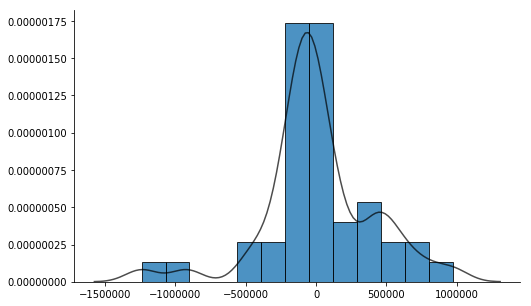

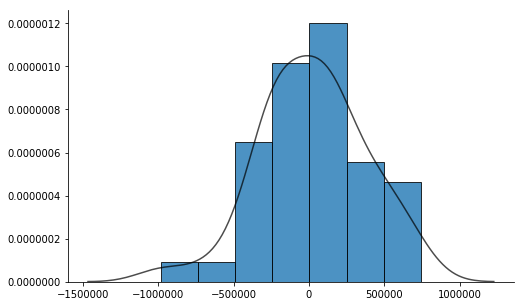

In [16]:
from plotting import histogram

histogram(residuos_1)
histogram(residuos_3)
plt.show()

El modelo que presenta un mejor comportamiento tanto en el error como en los residuos es el ModeloES_3, contrariamente a las suposiciones teóricas que se establecieron en el inicio.

# Predicciones del Modelo

/home/vanessa/miniconda3/envs/diplodatos-ayv/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


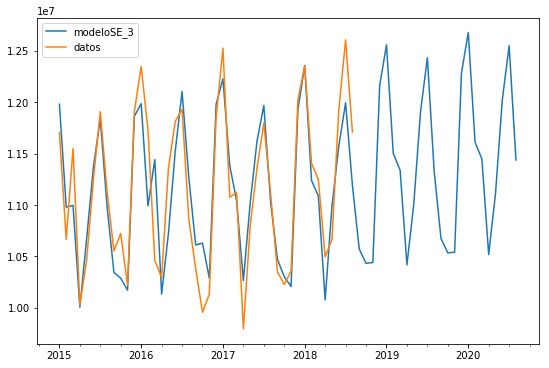

In [17]:
h=24

model = sm.tsa.ExponentialSmoothing(y, 
                    trend='add', damped=False, seasonal='mul', seasonal_periods=12).fit()

forecast = model.forecast(h)

plot = pd.DataFrame()
plot['modeloSE_3'] = pd.concat([modelES_3.fittedvalues, forecast])
plot['datos'] = y

plot.plot(figsize=(9,6));